## Imports and Functions

In [1]:
import numpy as np
import networkx as nx
from scipy.linalg import eigh, expm, sqrtm
from scipy.optimize import minimize
from scipy.special import binom
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import combinations, chain, product
from time import time

In [2]:
TOL = 1e-6
PROD_APX = .956

In [3]:
def powerset(iterable):
    "powerset([1,2,3]) --> [()] [(1,)] [(2,)] [(3,)] [(1, 2)] [(1, 3)] [(2, 3)] [(1, 2, 3)]"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [4]:
def add_weights(G, weight_type, scale=None):
    # differnt types of positively weighted graphs
    m = G.number_of_edges()
    if weight_type == 'unweighted':
        weights = np.ones(m)
    elif weight_type == 'zero':
        weights = np.zeros(m)
    elif weight_type == 'uniform':
        weights = np.random.uniform(low=0, high=1., size=m)
    elif weight_type == 'exponential':
        weights = np.random.exponential(scale=scale, size=m)
    else:
        raise ValueError('weight_type must be one of "unweighted", "zero","uniform", "gaussian", or "exponential"')
    for idx, (_,_,w) in enumerate(G.edges(data=True)):
        w['weight'] = weights[idx]
    return 

def unweighted_G(G):
    add_weights(G, 'unweighted')
    return 

def get_weight_sum(G):
    return G.size(weight="weight")

def get_maximum_eigval(H):
    return eigh(H, eigvals_only=True, subset_by_index=(H.shape[0]-1, H.shape[0]-1))[0]

def get_minimum_eigval(H):
    return eigh(H, eigvals_only=True, subset_by_index=(0, 0))[0]

def get_spectral_gap(H):
    eigvals = eigh(H, eigvals_only=True)
    # get unique eigenvalues within tolerance
    eigvals = np.unique(np.round(eigvals, 8))
    return eigvals[-1] - eigvals[-2]

def get_maximum_matching(G, return_edges=False):
    M_list = nx.max_weight_matching(G, weight='weight')
    if return_edges: return sum([G[u][v]['weight'] for u,v in M_list]), M_list
    else: return sum([G[u][v]['weight'] for u,v in M_list])

def is_valid_matching(edge_set):
    seen = set()
    for u, v in edge_set:
        if u in seen or v in seen:
            return False
        seen.add(u)
        seen.add(v)
    return True

def get_maximum_matching_k_edges(G, k, return_edges=False):
    best_matching = set()
    best_weight = float('-inf')
    # brute force all subsets of k edges
    for edge_combo in combinations(G.edges, k):
        if is_valid_matching(edge_combo):
            weight = sum(G[u][v].get("weight", 1) for u, v in edge_combo)
            if weight > best_weight:
                best_matching = set(edge_combo)
                best_weight = weight
    if not best_matching:
        raise ValueError(f"No matching of exactly {k} edges exists.")
    if return_edges:
        return best_weight, best_matching
    else:
        return best_weight

def get_maximum_matching_at_most_k_edges(G, k, return_edges=False):
    match_weight, max_matching = get_maximum_matching(G, return_edges=True)
    k_prime = len(max_matching)
    if k_prime <= k:
        if return_edges:
            return match_weight, max_matching
        else:
            return match_weight
    else:
        return get_maximum_matching_k_edges(G, k, return_edges=return_edges)

def calculate_cut_value(G, partition):
    cut_value = 0
    for edge in G.edges(data=True):
        u, v, weight = edge[0], edge[1], edge[2].get('weight', 1)
        if (u in partition and v not in partition) or (u not in partition and v in partition):
            cut_value += weight
    return cut_value

def get_maximum_cut(G, return_partitions=False):
    nodes = G.nodes
    n = len(nodes)
    weights = range(1, n // 2 + 1)
    max_cut_at_weight = {weight: 0 for weight in weights}
    # Iterate over all possible partitions
    for weight in weights:
        for subset in combinations(nodes, weight):
            cut_value = calculate_cut_value(G, set(subset))
            if cut_value > max_cut_at_weight[weight]:
                max_cut_at_weight[weight] = cut_value
    max_cut = max(max_cut_at_weight.values())
    if return_partitions:
        return max_cut, [k for k,v in max_cut_at_weight.items() if np.abs(v-max_cut)<TOL]
    else:
        return max_cut
    
def get_maximum_cut_and_edges(G):
    nodes = G.nodes
    n = len(nodes)
    weights = range(1, n // 2 + 1)
    max_cut = 0
    partitions = [] 
    # Iterate over all possible partitions
    for weight in weights:
        for subset in combinations(nodes, weight):
            cut_value = calculate_cut_value(G, set(subset))
            if cut_value > max_cut:
                max_cut = cut_value
                #partition = set(subset)
    for weight in weights:
        for subset in combinations(nodes, weight):
            cut_value = calculate_cut_value(G, set(subset))
            if np.abs(cut_value-max_cut)<TOL:
                partitions.append(set(subset))
    return max_cut, partitions
    
def get_maximum_k_cut(G, k):
    nodes = G.nodes
    n = len(nodes)
    max_cut = -np.inf
    # Iterate over all possible partitions
    for subset in combinations(nodes, k):
        cut_value = calculate_cut_value(G, set(subset))
        if cut_value > max_cut: 
            max_cut  = cut_value
    return max_cut

def get_energy_from_matching(W, M, ham_type='QMC'):
    if ham_type == 'XY' or ham_type == 'nXY':
        return M
    else:
        return (3*M + W)/2

def get_energy_from_cut(W, C, ham_type='QMC'):
    if ham_type == 'XY' or ham_type == 'nXY':
        return C-W/2
    else:
        return C

In [5]:
def test_factor_critical(G):
    n=G.number_of_nodes()
    if n % 2 == 0:
        return False
    for v in G.nodes:
        G_prime = G.copy()
        G_prime.remove_node(v)
        add_weights(G_prime, 'unweighted')
        M = get_maximum_matching(G_prime)
        if np.abs( M- (n-1)/2) >= TOL:
            return False
    return True

def test_two_vertex_connected(G):
    for v in G.nodes:
        G_prime = G.copy()
        G_prime.remove_node(v)
        if not nx.is_connected(G_prime):
            return False
    return True

def test_2vc_fc(G):
    return test_factor_critical(G)  and test_two_vertex_connected(G)

In [6]:
def get_token_graph(G, k):
    vertices = list(G.nodes)
    Gk = nx.Graph()
    token_nodes = list(combinations(vertices, k))
    Gk.add_nodes_from(token_nodes)
    for subset_1, subset_2 in combinations(token_nodes, 2):
        diff_1 = set(subset_1) - set(subset_2)
        diff_2 = set(subset_2) - set(subset_1)
        if len(diff_1) == 1 and len(diff_2) == 1:
            u, = diff_1
            v, = diff_2
            if G.has_edge(u, v):
                weight = G.get_edge_data(u, v, default={}).get('weight', 1)
                Gk.add_edge(subset_1, subset_2, weight=weight)
    return Gk

def get_laplacian_matrix(G, nodelist=None):
    return nx.laplacian_matrix(G, nodelist=nodelist).todense()
def get_adjacency_matrix(G, nodelist=None):
    return nx.adjacency_matrix(G, nodelist=nodelist).todense()
def get_signless_laplacian_matrix(G, nodelist=None):
    return np.diag(np.diag(get_laplacian_matrix(G, nodelist=nodelist))) + get_adjacency_matrix(G, nodelist=nodelist)

In [7]:
def convert_graph6_to_networkx(graph6):
    G = nx.from_graph6_bytes(graph6)
    return G

#all graphs up to size 8
def load_graphs():
    """load graph6 files from ../data/all_graphs.txt"""
    with open('data/all_graphs.txt', 'r') as f:
        graphs = f.read().splitlines()
    return [convert_graph6_to_networkx(graph.encode()) for graph in graphs]


In [8]:
def get_largest_spin_energy(energy_by_spin):
    return energy_by_spin[-1]

def get_largest_spin_energies(energies_by_spin):
    return np.array([get_largest_spin_energy(energy_by_spin) for energy_by_spin in energies_by_spin])

def get_max_spin_energy(energy_by_spin):
    return np.max(energy_by_spin)

def get_max_spin_energies(energies_by_spin):
    return np.array([get_max_spin_energy(energy_by_spin) for energy_by_spin in energies_by_spin])

In [92]:
def load_arrays(file_names, prefix='data/', allow_pickle=False):
    return [np.load(prefix + name + '.npy', allow_pickle=allow_pickle) for name in file_names]

def save_arrays(arrays, file_names, prefix='data/', allow_pickle=False):
    for arr, name in zip(arrays, file_names):
        if allow_pickle:
            np.save(prefix + name + '.npy', np.array(arr, dtype='object'), allow_pickle=allow_pickle)
        else:
            np.save(prefix + name + '.npy', np.array(arr), allow_pickle=allow_pickle)

def compute_and_append_energies(G, energy_lists):
    n = G.number_of_nodes()
    for k in range(1, n//2 + 1):
        Gk = get_token_graph(G, k)
        Lk = get_laplacian_matrix(Gk)
        Qk = get_signless_laplacian_matrix(Gk)
        Ak = get_adjacency_matrix(Gk)
        energy_lists[0].append(np.max(eigh(Lk, eigvals_only=True)))
        energy_lists[1].append(np.max(eigh(Qk, eigvals_only=True)))
        Ak_eigvals = eigh(Ak, eigvals_only=True)
        energy_lists[2].append(np.max(Ak_eigvals))
        energy_lists[3].append(-np.min(Ak_eigvals))

def compute_and_append_kcut_and_kmatch(G, kcut_list, kmatch_list):
    n = G.number_of_nodes()
    for k in range(1, n//2 + 1):
        max_kcut = get_maximum_k_cut(G, k)
        max_kmatch = get_maximum_matching_at_most_k_edges(G, k)
        kcut_list.append(max_kcut)
        kmatch_list.append(max_kmatch)

In [10]:
def safe_hist(arr, bins=200, alpha=.75, label=None):
    return plt.hist(arr+np.random.normal(0, 1e-6, size=len(arr)), bins=bins, alpha=alpha, label=label)

def plot_hists_by_n(energies, ns=None, match_energies=None, prod_energies=None, unique_ns=None, alg_names=None, xy=False):
    for n in unique_ns:
        n_idxs = np.where(ns==n)[0]
        max_energies_n = energies[n_idxs]
        match_energies_n = match_energies[n_idxs]
        prod_energies_n = prod_energies[n_idxs]
        if xy: 
            match_energies_n = match_energies_n/2
            prod_energies_n = prod_energies_n/2
        print(f"n={n}: {alg_names[0]} worst apx: {np.min(match_energies_n/max_energies_n):.2f}, {alg_names[1]} worst apx: {np.min(prod_energies_n/max_energies_n):.2f}, {alg_names[2]} worst apx: {np.min(np.maximum(match_energies_n, prod_energies_n)/max_energies_n):.2f}")
        plt.figure(figsize=(6,.75))
        safe_hist(match_energies_n/max_energies_n,  label=alg_names[0])
        safe_hist(prod_energies_n/max_energies_n, label=alg_names[1])
        safe_hist(np.maximum(match_energies_n, prod_energies_n)/max_energies_n, label=alg_names[2])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

def make_scatter_plots(energies, ns=None, match_energies=None, prod_energies=None, total_weights=None, prod_alg_name=None, existence_bound=True, alg_prod_apx=1, plot_bound=True):

    plt.figure(figsize=(4.5,3))
    small_x = np.linspace(.5,.75,100)
    big_x = np.linspace(.75,1,100)
    sc = plt.scatter(match_energies/energies, prod_energies/energies, c=total_weights, cmap='viridis', s=5)
    if plot_bound:
        plt.plot(small_x, 1.5-small_x, '--', color='grey', label='3/2-x')
        plt.legend()
    cbar = plt.colorbar(sc)
    cbar.set_label('W', rotation=0)
    x_min = np.min(match_energies/energies)
    # round x_min down to nearest .05
    xmin = np.floor(x_min*20)/20
    plt.xticks(np.arange(xmin,1.05,.05))
    plt.yticks(np.arange(.5,1.05,.05))
    #plt.ylim(.5,1)
    plt.xlim(xmin,1)
    plt.grid()
    plt.xlabel('MATCH / OPT')
    plt.ylabel(f'{prod_alg_name} / OPT')
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    best_alg_bound = np.min(np.maximum(match_energies, alg_prod_apx * prod_energies) / energies)
    sc = axs[0].scatter(ns, np.maximum(match_energies, alg_prod_apx * prod_energies) / energies, c=total_weights, cmap='viridis', s=5)
    cbar = plt.colorbar(sc, ax=axs[1])
    cbar.set_label('W', rotation=0)
    axs[0].set_title(f"Best Alg Bound: {best_alg_bound:.4f}")
    axs[0].set_xlabel('n')
    axs[0].set_ylabel('ALG / OPT')
    axs[0].grid()

    if existence_bound:
        best_existence_bound = np.min(np.maximum(match_energies, prod_energies) / energies)
        sc = axs[1].scatter(ns, np.maximum(match_energies, prod_energies) / energies, c=total_weights, cmap='viridis', s=5)
        cbar = plt.colorbar(sc, ax=axs[0])
        cbar.set_label('W', rotation=0)
        axs[1].set_title(f"Best Existence Bound: {best_existence_bound:.4f}")
        axs[1].set_xlabel('n')
        axs[1].set_ylabel('ALG\' / OPT')
        axs[1].grid()

    plt.tight_layout()
    plt.show()

def plot_best_and_worst_graphs(energies, graphs=None, match_energies=None, prod_energies=None, keep=10):
    worst_idxs = np.argsort(np.maximum(match_energies, prod_energies) / energies)[:keep]
    plt.figure(figsize=(1.5*keep, 1))
    for i, idx in enumerate(worst_idxs):  # Limit to 5 subplots
        plt.subplot(1, keep, i + 1)
        nx.draw(graphs[idx], node_size=50)
        plt.title(np.round(np.maximum(match_energies[idx], prod_energies[idx]) / energies[idx], 4))
    plt.show()

    best_idxs = np.argsort(np.maximum(match_energies, prod_energies) / energies)[-keep:]
    plt.figure(figsize=(1.5*keep, 1))
    for i, idx in enumerate(best_idxs):  # Limit to 5 subplots
        plt.subplot(1, keep, i + 1)
        nx.draw(graphs[idx], node_size=50)
        plt.title(np.round(np.maximum(match_energies[idx], prod_energies[idx]) / energies[idx], 4))
    plt.show()

## Unweighted Graphs

### Compute or Load Stats


All non-isomorphic $n\leq 9$ graphs (credit [Brendan McKay](https://users.cecs.anu.edu.au/~bdm/data/graphs.html))

loading takes ~25 seconds

In [11]:
all_graphs = load_graphs()
# TESTING only graphs up to size 7
#all_graphs = [G for G in all_graphs if G.number_of_nodes() <= 7]
ns = np.array([G.number_of_nodes() for G in all_graphs])
unique_ns = np.unique(ns)
total_weights = np.array([G.number_of_edges() for G in all_graphs])
# get maximum degree of each graph
max_degrees = np.array([max([d for _,d in G.degree()]) for G in all_graphs])
# we will compute flattened arrays that loop over all graphs and all k from 1 to n//2 (where n is irregular, as it is the number of nodes)
# as such, we create an index map that goes from this flattened array to the original graph and k
index_map = []
for graph_idx, G in enumerate(all_graphs):
    n = G.number_of_nodes()
    for k in range(1, n // 2 + 1):
        index_map.append((graph_idx, k))
print(len(all_graphs))

PATH_AND_CYCLE_NS = np.arange(2,14)
ODD_CYCLE_NS = np.arange(3,14,2)
# reload if already computed, otherwise will save in data folder
PRECOMPUTED_UNWEIGHTED_DATA = True
PRECOMPUTED_PATH_AND_CYCLE_DATA = True
PRECOMPUTED_2VC_FC_IDXS = True

energy_keys = ['max_Lk_energies', 'max_Qk_energies', 'max_Ak_energies', 'max_nAk_energies']
cut_match_keys = ['cuts', 'matches']
path_keys = ['max_path_' + k for k in energy_keys]
cycle_keys = ['max_cycle_' + k for k in energy_keys]

273192


In [12]:
if PRECOMPUTED_UNWEIGHTED_DATA:
    max_Lk_energies, max_Qk_energies, max_Ak_energies, max_nAk_energies = load_arrays(energy_keys, allow_pickle=True)
    cuts, matches = load_arrays(cut_match_keys)
else:
    max_Lk_energies, max_Qk_energies = [[] for _ in all_graphs], [[] for _ in all_graphs]
    max_Ak_energies, max_nAk_energies = [[] for _ in all_graphs], [[] for _ in all_graphs]
    cuts, matches = np.zeros(len(all_graphs)), np.zeros(len(all_graphs))

    for idx, G in tqdm(enumerate(all_graphs)):
        add_weights(G, 'unweighted')
        cuts[idx] = get_maximum_cut(G)
        matches[idx] = get_maximum_matching(G)
        for k in range(1, G.number_of_nodes() // 2 + 1):
            Gk = get_token_graph(G, k)
            Lk = get_laplacian_matrix(Gk)
            Qk = get_signless_laplacian_matrix(Gk)
            Ak = get_adjacency_matrix(Gk)
            max_Lk_energies[idx].append(np.max(eigh(Lk, eigvals_only=True)))
            max_Qk_energies[idx].append(np.max(eigh(Qk, eigvals_only=True)))
            Ak_eigvals = eigh(Ak, eigvals_only=True)
            max_Ak_energies[idx].append(np.max(Ak_eigvals))
            max_nAk_energies[idx].append(-np.min(Ak_eigvals))

    save_arrays([max_Lk_energies, max_Qk_energies, max_Ak_energies, max_nAk_energies], energy_keys, allow_pickle=True)
    save_arrays([cuts, matches], cut_match_keys)

In [13]:
def compute_and_save_token_graph_data(graph_fn, n_vals, prefix):
    Ls, Qs, As, nAs = [[] for _ in n_vals], [[] for _ in n_vals], [[] for _ in n_vals], [[] for _ in n_vals]
    cuts, matches = np.zeros(len(n_vals)), np.zeros(len(n_vals))

    for idx, n in tqdm(enumerate(n_vals)):
        G = graph_fn(n)
        add_weights(G, 'unweighted')
        cuts[idx] = get_maximum_cut(G)
        matches[idx] = get_maximum_matching(G)
        for k in range(1, n//2 + 1):
            Gk = get_token_graph(G, k)
            Ls[idx].append(get_maximum_eigval(get_laplacian_matrix(Gk)))
            Qs[idx].append(get_maximum_eigval(get_signless_laplacian_matrix(Gk)))
            A = get_adjacency_matrix(Gk)
            As[idx].append(get_maximum_eigval(A))
            nAs[idx].append(get_maximum_eigval(-A))
    save_arrays([Ls, Qs, As, nAs], [prefix + k for k in energy_keys], allow_pickle=True)
    save_arrays([cuts, matches], [prefix + k for k in cut_match_keys], allow_pickle=False)

    
if PRECOMPUTED_PATH_AND_CYCLE_DATA:
    (path_Lk_energies, path_Qk_energies, path_Ak_energies, path_nAk_energies) = load_arrays(energy_keys, prefix='data/path_', allow_pickle=True)
    path_matches, path_cuts = load_arrays(cut_match_keys, prefix='data/path_', allow_pickle=False)
    (cycle_Lk_energies, cycle_Qk_energies, cycle_Ak_energies, cycle_nAk_energies) = load_arrays(energy_keys, prefix='data/cycle_', allow_pickle=True)
    cycle_matches, cycle_cuts = load_arrays(cut_match_keys, prefix='data/cycle_', allow_pickle=False)

else:
    compute_and_save_token_graph_data(nx.path_graph, PATH_AND_CYCLE_NS, 'path_')
    compute_and_save_token_graph_data(nx.cycle_graph, PATH_AND_CYCLE_NS, 'cycle_')

In [14]:
if PRECOMPUTED_2VC_FC_IDXS:
    two_vc_fc_idxs = np.load('data/two_vc_fc_idxs.npy')
else:
    two_vc_fc_idxs = [idx for idx, G in enumerate(all_graphs) if test_2vc_fc(G)]
    np.save('data/two_vc_fc_idxs.npy', two_vc_fc_idxs)

In [15]:
match_energies = get_energy_from_matching(total_weights, matches)
cut_energies = get_energy_from_cut(total_weights, cuts)
match_energies_xy = get_energy_from_matching(total_weights, matches, ham_type='XY')
cut_energies_xy = get_energy_from_cut(total_weights, cuts, ham_type='XY')
cs = cuts/total_weights 
ms = matches/total_weights 
max_qmc_energies = get_max_spin_energies(max_Lk_energies)
max_epr_energies = get_max_spin_energies(max_Qk_energies)
max_xy_energies = get_max_spin_energies(max_nAk_energies)
max_nxy_energies = get_max_spin_energies(max_Ak_energies)
opt_qmcs = max_qmc_energies / total_weights
opt_eprs = max_epr_energies / total_weights
opt_xy = max_xy_energies / total_weights
opt_nxy = max_nxy_energies / total_weights

### Analyze Unweighted Graphs

##### Testing OPT conjectures

Conjecture 1: OPT $\leq W+M$     (EPR and QMC)

Conjecture 2: OPT $\leq \frac{W+C}{2} + M$  (QMC)

In [69]:
# Test conjecture 1 and 2 for EPR and QMC
conjecture_1_slack_epr = []
conjecture_1_slack_qmc = []
conjecture_2_slack_qmc = []
for idx in tqdm(range(len(all_graphs))):
    G = all_graphs[idx]
    n = ns[idx]
    W = total_weights[idx]
    C = cuts[idx]
    M = matches[idx]
    max_EPR = max_epr_energies[idx]
    max_QMC = max_qmc_energies[idx]
    conjecture_1_slack_epr.append((W + M)/max_EPR)
    conjecture_1_slack_qmc.append((W + M)/max_QMC)
    conjecture_2_slack_qmc.append(((W + C)/2 + M) / max_QMC)
    if max_EPR > W + M + TOL:
        print(f"Graph {idx} failed W+M for EPR")
    if  max_QMC > (W+C)/2 + M + TOL:
        print(f"Graph {idx} failed (W+C)/2+M QMC")
    
conjecture_1_slack_epr = np.array(conjecture_1_slack_epr)
conjecture_2_slack_qmc = np.array(conjecture_2_slack_qmc)
conjecture_2_slack_qmc = np.array(conjecture_2_slack_qmc)

100%|██████████| 273192/273192 [00:00<00:00, 347214.95it/s]


tight cases for conjecture 1 EPR


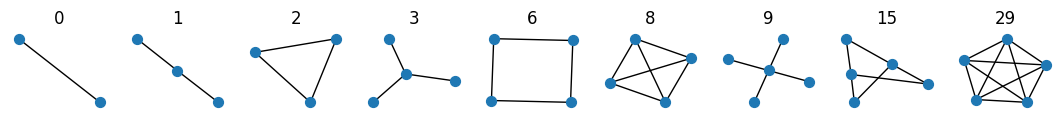

tight cases for conjecture 1 QMC


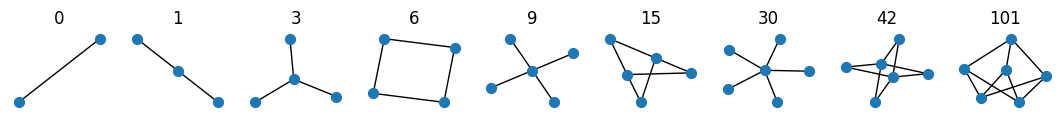

tight cases for conjecture 2 QMC


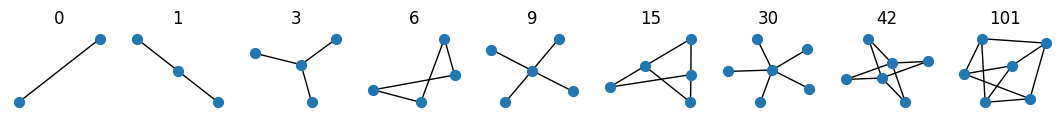

In [70]:
def plot_tight_conjecture_graphs(conjecture_slack, keep=10):

    plt.figure(figsize=(1.5*keep, 1))
    kept = 1
    for idx, val in enumerate(conjecture_slack):
        if kept >= keep:
                break
        if np.abs(val - 1) < TOL:
            plt.subplot(1, keep, kept)
            nx.draw(all_graphs[idx], node_size=50)
            plt.title(f'{idx}')
            kept += 1
    plt.show()
            

print('tight cases for conjecture 1 EPR')
plot_tight_conjecture_graphs(conjecture_1_slack_epr, keep=10)
print('tight cases for conjecture 1 QMC')
plot_tight_conjecture_graphs(conjecture_1_slack_qmc, keep=10)
print('tight cases for conjecture 2 QMC')
plot_tight_conjecture_graphs(conjecture_2_slack_qmc, keep=10)

##### Testing token graph conjectures

Conjecture 1: OPT $\leq W+k$     (EPR and QMC)

Conjecture 2: OPT $\leq \frac{W+C}{2} + k$  (QMC)

In [71]:
# Test conjecture 1 and 2 for EPR and QMC
token_conjecture_1_slack_epr = []
token_conjecture_1_slack_qmc = []
token_conjecture_2_slack_qmc = []
for idx in tqdm(range(len(all_graphs))):
    G = all_graphs[idx]
    n = ns[idx]
    W = total_weights[idx]
    C = cuts[idx]
    for k in range(1, n//2 + 1):
        max_Lk_eigval = max_Lk_energies[idx][k-1]
        max_Qk_eigval = max_Qk_energies[idx][k-1]
        token_conjecture_1_slack_epr.append((W + k)/max_Qk_eigval)
        token_conjecture_1_slack_qmc.append((W + k)/max_Lk_eigval)
        token_conjecture_2_slack_qmc.append(((W + C)/2 + k) / max_Lk_eigval)
        if max_Qk_eigval > W + k + TOL:
            print(f"Graph {idx} failed W+k for EPR at k={k}")
        if  max_Lk_eigval > (W+C)/2 + k + TOL:
            print(f"Graph {idx} failed (W+C)/2+k QMC at k={k}")
    
token_conjecture_1_slack_epr = np.array(token_conjecture_1_slack_epr)
token_conjecture_2_slack_qmc = np.array(token_conjecture_2_slack_qmc)
token_conjecture_2_slack_qmc = np.array(token_conjecture_2_slack_qmc)

100%|██████████| 273192/273192 [00:03<00:00, 70165.12it/s]


tight cases for conjecture 1 EPR


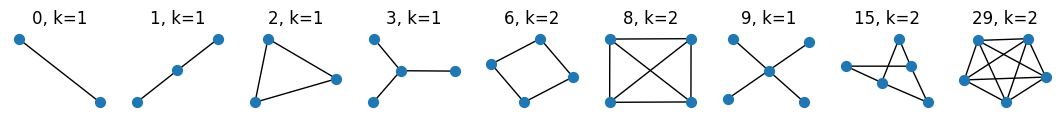

tight cases for conjecture 1 QMC


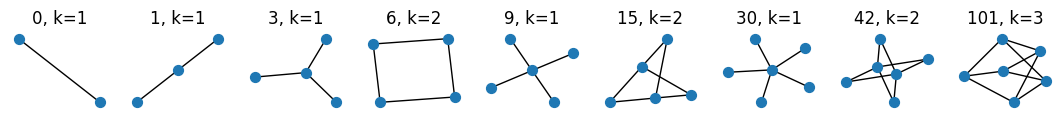

tight cases for conjecture 2 QMC


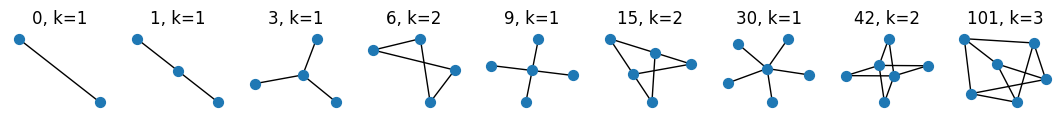

In [72]:
def plot_tight_token_conjecture_graphs(conjecture_slack, keep=10):

    plt.figure(figsize=(1.5*keep, 1))
    kept = 1
    for idx, val in enumerate(conjecture_slack):
        if kept >= keep:
                break
        if np.abs(val - 1) < TOL:
            G_idx, k = index_map[idx]
            plt.subplot(1, keep, kept)
            nx.draw(all_graphs[G_idx], node_size=50)
            plt.title(f'{G_idx}, k={k}')
            kept += 1
    plt.show()
            

print('tight cases for conjecture 1 EPR')
plot_tight_token_conjecture_graphs(token_conjecture_1_slack_epr, keep=10)
print('tight cases for conjecture 1 QMC')
plot_tight_token_conjecture_graphs(token_conjecture_1_slack_qmc, keep=10)
print('tight cases for conjecture 2 QMC')
plot_tight_token_conjecture_graphs(token_conjecture_2_slack_qmc, keep=10)

##### Testing MATCH and PROD algorithms

QMC

n=2: MATCH worst apx: 1.00, CUT worst apx: 0.50, ALG' worst apx: 1.00


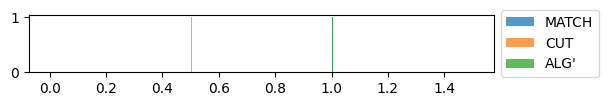

n=3: MATCH worst apx: 0.83, CUT worst apx: 0.67, ALG' worst apx: 0.83


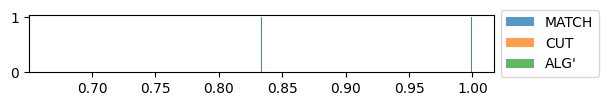

n=4: MATCH worst apx: 0.75, CUT worst apx: 0.60, ALG' worst apx: 0.75


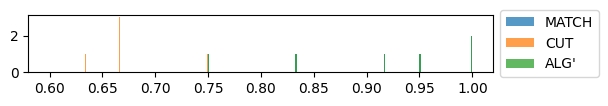

n=5: MATCH worst apx: 0.70, CUT worst apx: 0.64, ALG' worst apx: 0.75


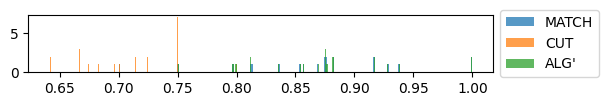

n=6: MATCH worst apx: 0.67, CUT worst apx: 0.62, ALG' worst apx: 0.75


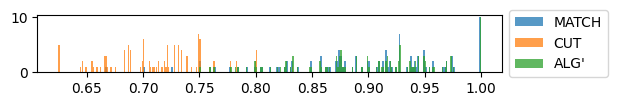

n=7: MATCH worst apx: 0.64, CUT worst apx: 0.64, ALG' worst apx: 0.76


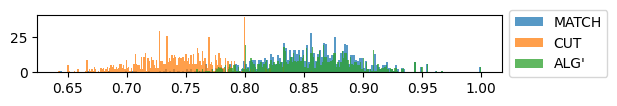

n=8: MATCH worst apx: 0.62, CUT worst apx: 0.63, ALG' worst apx: 0.76


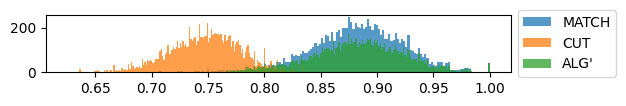

n=9: MATCH worst apx: 0.61, CUT worst apx: 0.64, ALG' worst apx: 0.75


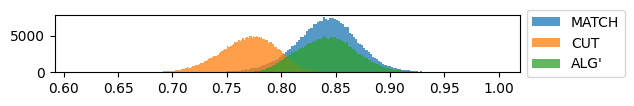

In [20]:
plot_hists_by_n(max_qmc_energies, ns=ns, unique_ns=unique_ns, match_energies=match_energies, prod_energies=cut_energies, alg_names=['MATCH', 'CUT', 'ALG\''])

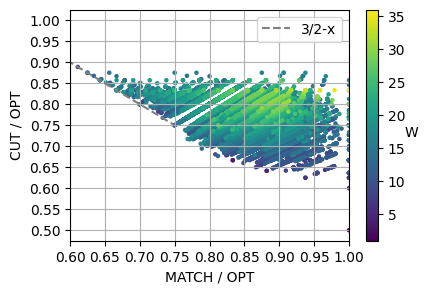

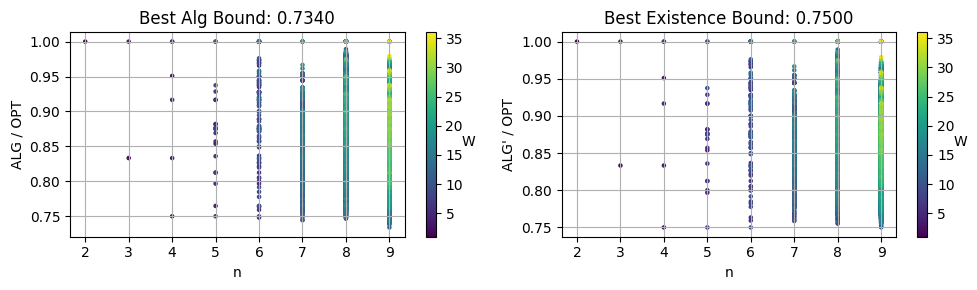

In [21]:
make_scatter_plots(max_qmc_energies, ns=ns, match_energies=match_energies, prod_energies=cut_energies, total_weights=total_weights, prod_alg_name='CUT', existence_bound=True, alg_prod_apx=PROD_APX, plot_bound=True)

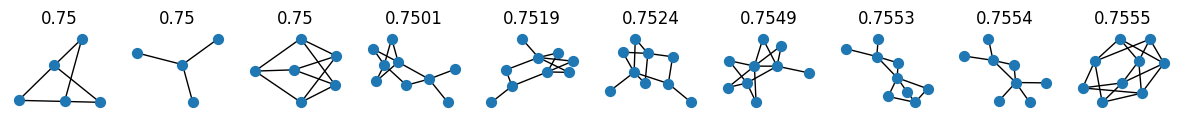

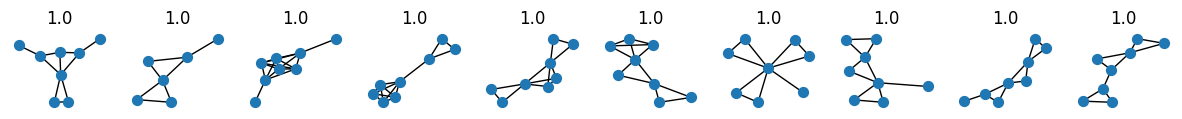

In [22]:
plot_best_and_worst_graphs(max_qmc_energies, graphs=all_graphs, match_energies=match_energies, prod_energies=cut_energies, keep=10)

All worst cases (.75 approx) are complete bipartite graphs with larger partition of size 3. Best cases (1.0 approx) are vertex or edge unions of cliques

EPR

n=2: MATCH worst apx: 1.00, ZERO worst apx: 0.50, ALG worst apx: 1.00


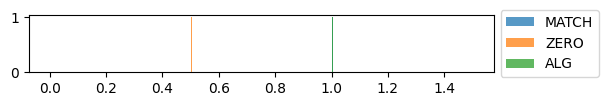

n=3: MATCH worst apx: 0.75, ZERO worst apx: 0.67, ALG worst apx: 0.75


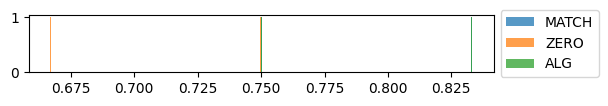

n=4: MATCH worst apx: 0.75, ZERO worst apx: 0.63, ALG worst apx: 0.75


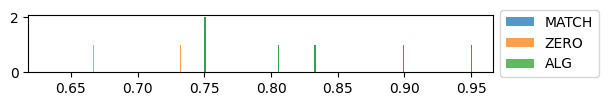

n=5: MATCH worst apx: 0.67, ZERO worst apx: 0.68, ALG worst apx: 0.75


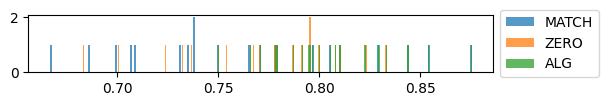

n=6: MATCH worst apx: 0.67, ZERO worst apx: 0.67, ALG worst apx: 0.75


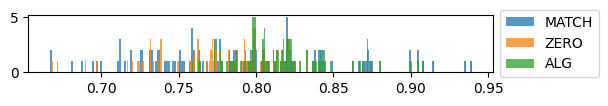

n=7: MATCH worst apx: 0.62, ZERO worst apx: 0.69, ALG worst apx: 0.76


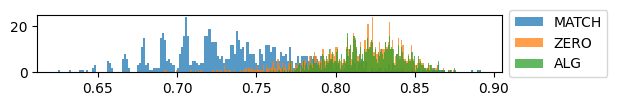

n=8: MATCH worst apx: 0.62, ZERO worst apx: 0.68, ALG worst apx: 0.76


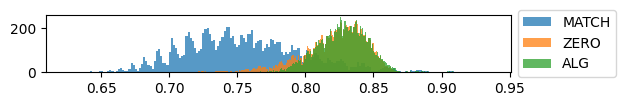

n=9: MATCH worst apx: 0.60, ZERO worst apx: 0.70, ALG worst apx: 0.76


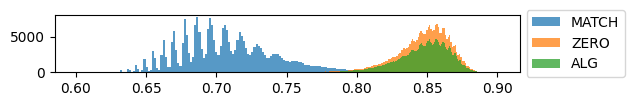

In [23]:
plot_hists_by_n(max_epr_energies, ns=ns, unique_ns=unique_ns, match_energies=match_energies, prod_energies=total_weights, alg_names=['MATCH', 'ZERO', 'ALG'])

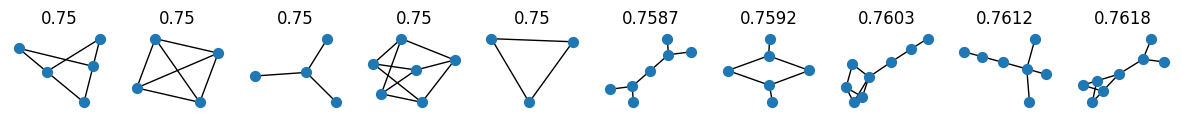

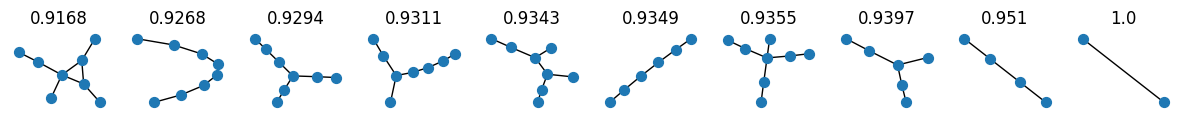

In [24]:
plot_best_and_worst_graphs(max_epr_energies, graphs=all_graphs, match_energies=match_energies, prod_energies=total_weights, keep=10)

All worst cases (.75 approx) are complete bipartite graphs with larger partition of size 3, or K_3 and K_4. Best cases seem to be close to paths and cycles

XY

n=2: MATCH worst apx: 1.00, CUT worst apx: 0.50, ALG' worst apx: 1.00


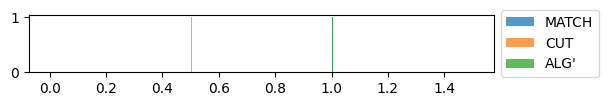

n=3: MATCH worst apx: 0.71, CUT worst apx: 0.50, ALG' worst apx: 0.71


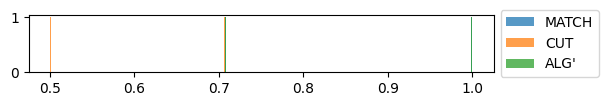

n=4: MATCH worst apx: 0.50, CUT worst apx: 0.50, ALG' worst apx: 0.71


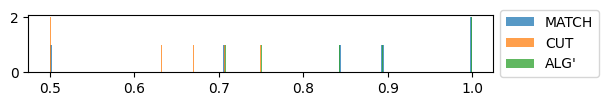

n=5: MATCH worst apx: 0.41, CUT worst apx: 0.50, ALG' worst apx: 0.68


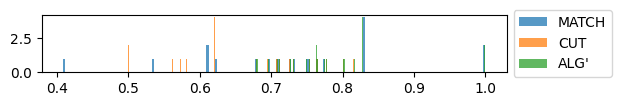

n=6: MATCH worst apx: 0.33, CUT worst apx: 0.50, ALG' worst apx: 0.64


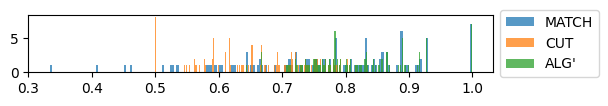

n=7: MATCH worst apx: 0.29, CUT worst apx: 0.50, ALG' worst apx: 0.61


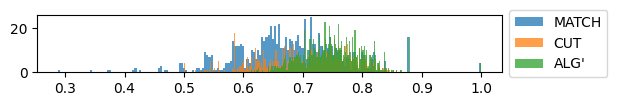

n=8: MATCH worst apx: 0.25, CUT worst apx: 0.50, ALG' worst apx: 0.60


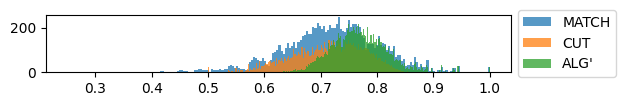

n=9: MATCH worst apx: 0.22, CUT worst apx: 0.50, ALG' worst apx: 0.58


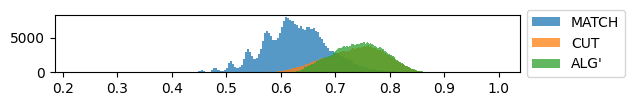

In [25]:
plot_hists_by_n(max_xy_energies, ns=ns, unique_ns=unique_ns, match_energies=match_energies_xy, prod_energies=cut_energies_xy, alg_names=['MATCH', 'CUT', 'ALG\''])

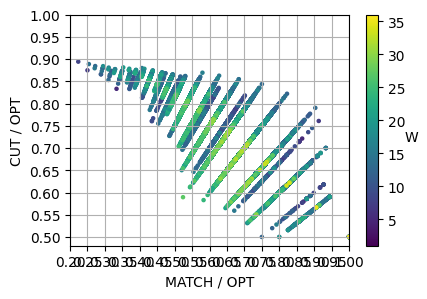

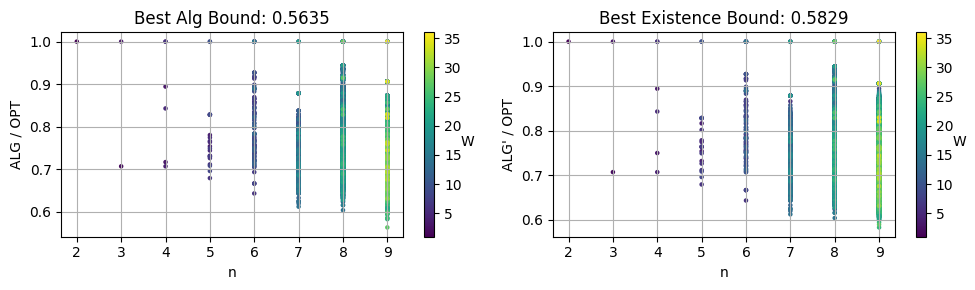

In [26]:
make_scatter_plots(max_xy_energies, ns=ns, match_energies=match_energies_xy, prod_energies=cut_energies_xy, total_weights=total_weights, prod_alg_name='CUT', existence_bound=True, alg_prod_apx=PROD_APX,plot_bound=False)

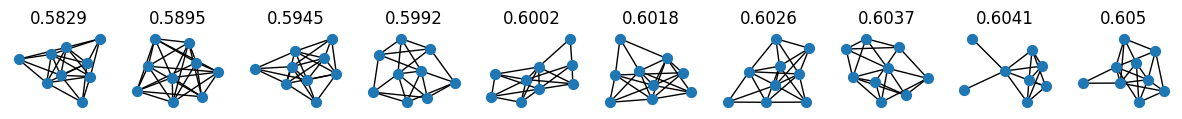

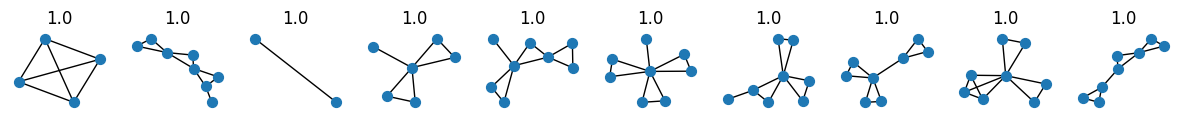

In [27]:
plot_best_and_worst_graphs(max_xy_energies, graphs=all_graphs, match_energies=match_energies_xy, prod_energies=cut_energies_xy, keep=10)

Worst cases are strange. Best cases are vertex-unions of cliques

$XY^-$

n=2: MATCH worst apx: 1.00, ZERO worst apx: 0.50, ALG worst apx: 1.00


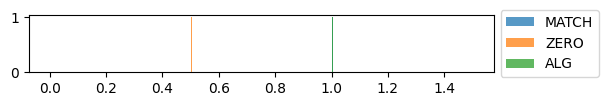

n=3: MATCH worst apx: 0.50, ZERO worst apx: 0.71, ALG worst apx: 0.71


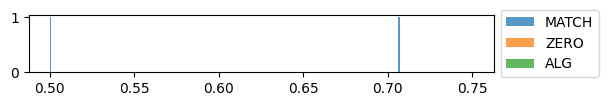

n=4: MATCH worst apx: 0.50, ZERO worst apx: 0.67, ALG worst apx: 0.71


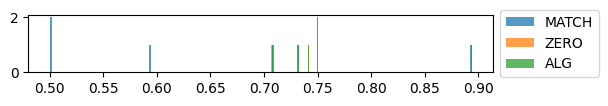

n=5: MATCH worst apx: 0.33, ZERO worst apx: 0.73, ALG worst apx: 0.73


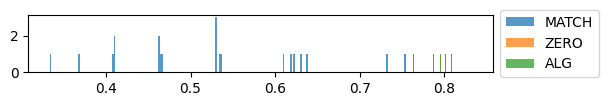

n=6: MATCH worst apx: 0.33, ZERO worst apx: 0.72, ALG worst apx: 0.74


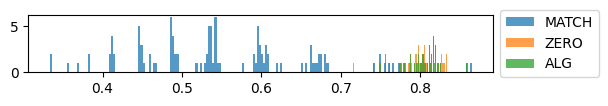

n=7: MATCH worst apx: 0.25, ZERO worst apx: 0.74, ALG worst apx: 0.74


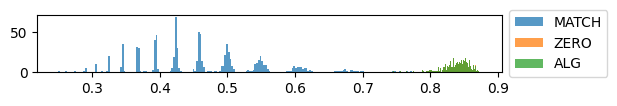

n=8: MATCH worst apx: 0.25, ZERO worst apx: 0.74, ALG worst apx: 0.75


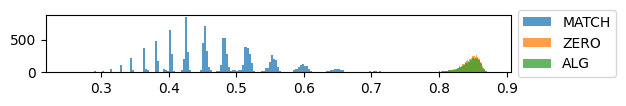

n=9: MATCH worst apx: 0.20, ZERO worst apx: 0.75, ALG worst apx: 0.75


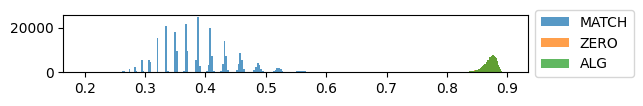

In [28]:
plot_hists_by_n(max_nxy_energies, ns=ns, unique_ns=unique_ns, match_energies=match_energies_xy, prod_energies=total_weights/2, alg_names=['MATCH', 'ZERO', 'ALG'])

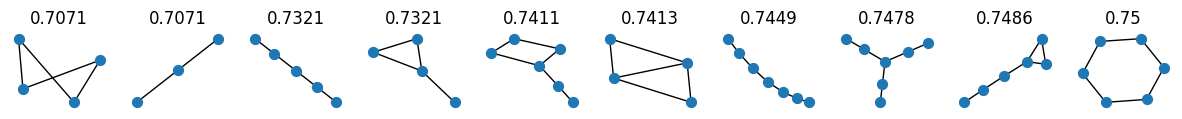

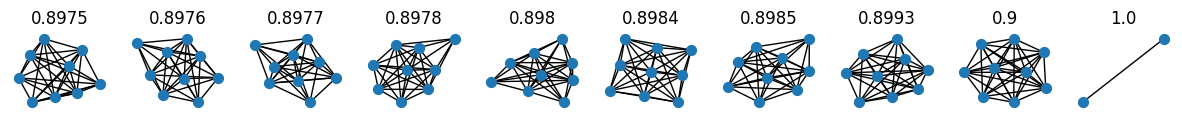

In [29]:
plot_best_and_worst_graphs(max_nxy_energies, graphs=all_graphs, match_energies=match_energies_xy, prod_energies=total_weights/2, keep=10)

Worst cases are close to paths and cycles (sparse). Best cases are close to cliques (dense)

##### Testing OPT always in k//2

In [30]:
for data in [max_Lk_energies, max_Qk_energies, max_Ak_energies, max_nAk_energies]:
    print(np.allclose(get_largest_spin_energies(data), get_max_spin_energies(data)))

True
True
True
False


In [31]:
fail_idxs = np.where(get_largest_spin_energies(max_nAk_energies) < get_max_spin_energies(max_nAk_energies)-TOL)[0]

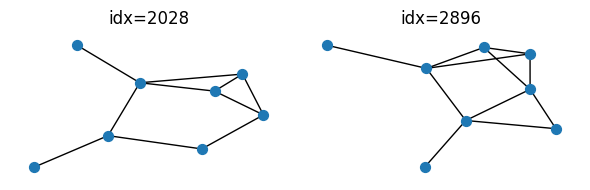

In [32]:
num_graphs = len(fail_idxs[:10])
fig, axes = plt.subplots(1, num_graphs, figsize=(3 * num_graphs, 2))
# If only one graph, axes isn't a list — force it to be iterable
if num_graphs == 1:
    axes = [axes]
for ax, idx in zip(axes, fail_idxs[:10]):
    G = all_graphs[idx]
    nx.draw(G, ax=ax, node_size=50)
    ax.set_title(f"idx={idx}")
    ax.set_axis_off()
plt.tight_layout()
plt.show()

In [33]:
G = all_graphs[2028]
n = G.number_of_nodes()
for k in range(1, n//2 + 1):
    Gk = get_token_graph(G, k)
    Ak = get_adjacency_matrix(Gk)
    Ak_eigvals = np.linalg.eigvalsh(Ak)
    max_Ak_eigval = np.max(Ak_eigvals)
    min_Ak_eigval = np.min(Ak_eigvals)
    print(f"k={k}:  Ak: {max_Ak_eigval}, -Ak: {-min_Ak_eigval}")

k=1:  Ak: 2.8903741245414665, -Ak: 2.083696893409347
k=2:  Ak: 4.800596857271172, -Ak: 3.455845931416418
k=3:  Ak: 5.8200241514741435, -Ak: 4.471774701625339
k=4:  Ak: 6.108035168107578, -Ak: 4.4703954397466195


## Weighted Graphs

### Compute or Load Stats

In [89]:
PRECOMPUTED_WEIGHTED_DATA=False

In [90]:
weighted_graph_keys = ['weighted_graphs', 'weighted_total_weights']
weighted_energy_keys = ['weighted_max_Lk_energies', 'weighted_max_Qk_energies', 'weighted_max_Ak_energies', 'weighted_max_nAk_energies']
weighted_cut_match_keys = ['weighted_cuts', 'weighted_matches']
weight_kcut_kmatch_keys = ['weighted_kcut', 'weighted_kmatch']
WEIGHTED_NS = np.array([4,5,6,7,8,9,10])
WEIGHTED_NS = np.array([4,5,6,7]) # for testing, comment out later
WEIGHTED_TRIALS_BY_N = 2**(20-WEIGHTED_NS)//100

weighted_num_graphs =4*sum(WEIGHTED_TRIALS_BY_N) # four types of weights per trial

weighted_idx_map = []
for n, trials in zip(WEIGHTED_NS, WEIGHTED_TRIALS_BY_N):
    for _ in range(trials):
        for k in range(1, n // 2 + 1):
            weighted_idx_map.extend([(n, k)] * 4)

In [93]:
if PRECOMPUTED_WEIGHTED_DATA:
    weighted_graphs, weighted_total_weights = load_arrays(weighted_graph_keys, allow_pickle=True)
    weighted_max_Lk_energies, weighted_max_Qk_energies, weighted_max_Ak_energies, weighted_max_nAk_energies = load_arrays(weighted_energy_keys, allow_pickle=True)
    weighted_cuts, weighted_matches = load_arrays(weighted_cut_match_keys)
    weighted_kcuts, weighted_kmatches = load_arrays(weighted_cut_match_keys, allow_pickle=True)
else:
    weighted_graphs, weighted_total_weights = [], []
    weighted_max_Lk_energies, weighted_max_Qk_energies = [[] for _ in range(weighted_num_graphs)], [[] for _ in range(weighted_num_graphs)]
    weighted_max_Ak_energies, weighted_max_nAk_energies = [[] for _ in range(weighted_num_graphs)], [[] for _ in range(weighted_num_graphs)]
    weighted_cuts, weighted_matches = [], []
    weighted_kcuts, weighted_kmatches = [[] for _ in range(weighted_num_graphs)], [[] for _ in range(weighted_num_graphs)]
    idx = 0
    for N, trials in zip(WEIGHTED_NS, WEIGHTED_TRIALS_BY_N):
        
        for _ in tqdm(range(trials)):
            # uniform weighted complete graphs
            G = nx.complete_graph(N)
            add_weights(G, 'uniform')
            total_weight = get_weight_sum(G)
            compute_and_append_energies(G, [weighted_max_Lk_energies[idx], weighted_max_Qk_energies[idx], weighted_max_Ak_energies[idx], weighted_max_nAk_energies[idx]])
            weighted_graphs.append(G)
            weighted_total_weights.append(total_weight)
            weighted_cuts.append(get_maximum_cut(G))
            weighted_matches.append(get_maximum_matching(G))
            compute_and_append_kcut_and_kmatch(G, weighted_kcuts[idx], weighted_kmatches[idx])
            idx+=1
            # connected Erdos renyi graph
            for trial in range(100):
                G = nx.erdos_renyi_graph(N, np.random.uniform(.1, 1))
                if nx.is_connected(G):
                    break
            add_weights(G, 'uniform')
            total_weight = get_weight_sum(G)
            compute_and_append_energies(G, [weighted_max_Lk_energies[idx], weighted_max_Qk_energies[idx], weighted_max_Ak_energies[idx], weighted_max_nAk_energies[idx]])
            weighted_graphs.append(G)
            weighted_total_weights.append(total_weight)
            weighted_cuts.append(get_maximum_cut(G))
            weighted_matches.append(get_maximum_matching(G))
            compute_and_append_kcut_and_kmatch(G, weighted_kcuts[idx], weighted_kmatches[idx])
            idx += 1
            # exponentially weighted complete graph
            G = nx.complete_graph(N)
            add_weights(G, 'exponential', scale=1)
            total_weight = get_weight_sum(G)
            compute_and_append_energies(G, [weighted_max_Lk_energies[idx], weighted_max_Qk_energies[idx], weighted_max_Ak_energies[idx], weighted_max_nAk_energies[idx]])
            weighted_graphs.append(G)
            weighted_total_weights.append(total_weight)    
            weighted_cuts.append(get_maximum_cut(G))
            weighted_matches.append(get_maximum_matching(G))
            compute_and_append_kcut_and_kmatch(G, weighted_kcuts[idx], weighted_kmatches[idx])
            idx += 1
            # strongly exponenitally weighted  complete graph
            G = nx.complete_graph(N)
            add_weights(G, 'exponential', scale=10)
            total_weight = get_weight_sum(G)
            compute_and_append_energies(G, [weighted_max_Lk_energies[idx], weighted_max_Qk_energies[idx], weighted_max_Ak_energies[idx], weighted_max_nAk_energies[idx]])
            weighted_graphs.append(G)
            weighted_total_weights.append(total_weight)
            weighted_cuts.append(get_maximum_cut(G))
            weighted_matches.append(get_maximum_matching(G))
            compute_and_append_kcut_and_kmatch(G, weighted_kcuts[idx], weighted_kmatches[idx])
            idx+=1
    weighted_Lk_energies = weighted_max_Lk_energies
    weighted_Qk_energies = weighted_max_Qk_energies
    weighted_Ak_energies = weighted_max_Ak_energies
    weighted_nAk_energies = weighted_max_nAk_energies
    weighted_cuts  = np.array(weighted_cuts)
    weighted_matches = np.array(weighted_matches)
    weighted_total_weights = np.array(weighted_total_weights)

    save_arrays([weighted_max_Lk_energies, weighted_max_Qk_energies, weighted_max_Ak_energies, weighted_max_nAk_energies], weighted_energy_keys, allow_pickle=True)
    save_arrays([weighted_graphs, weighted_total_weights], weighted_graph_keys, allow_pickle=True)
    save_arrays([weighted_cuts, weighted_matches], weighted_cut_match_keys)

  0%|          | 0/655 [00:00<?, ?it/s]

100%|██████████| 81/81 [00:02<00:00, 28.49it/s]


In [94]:
weighted_ns = np.array([G.number_of_nodes() for G in weighted_graphs])
weighted_unique_ns = np.unique(weighted_ns)
weighted_match_energies = get_energy_from_matching(weighted_total_weights, weighted_matches)
weighted_cut_energies = get_energy_from_cut(weighted_total_weights, weighted_cuts)
weighted_match_energies_xy = get_energy_from_matching(weighted_total_weights, weighted_matches, ham_type='XY')
weighted_cut_energies_xy = get_energy_from_cut(weighted_total_weights, weighted_cuts, ham_type='XY')
weighted_cs = weighted_cuts/weighted_total_weights 
weighted_ms = weighted_matches/weighted_total_weights 
weighted_max_qmc_energies = get_max_spin_energies(weighted_max_Lk_energies)
weighted_max_epr_energies = get_max_spin_energies(weighted_max_Qk_energies)
weighted_max_xy_energies = get_max_spin_energies(weighted_max_nAk_energies)
weighted_max_nxy_energies = get_max_spin_energies(weighted_max_Ak_energies)
weighted_opt_qmcs = weighted_max_qmc_energies / weighted_total_weights
weighted_opt_eprs = weighted_max_epr_energies / weighted_total_weights
weighted_opt_xy = weighted_max_xy_energies / weighted_total_weights
weighted_opt_nxy = weighted_max_nxy_energies / weighted_total_weights

### Analyze Weighted Graphs

##### Testing OPT conjectures

Conjecture 1: OPT $\leq W+M$     (EPR and QMC)

Conjecture 2: OPT $\leq \frac{W+C}{2} + M$  (QMC)

In [95]:
# Test conjecture 1 and 2 for EPR and QMC
conjecture_1_slack_epr = []
conjecture_1_slack_qmc = []
conjecture_2_slack_qmc = []
for idx in tqdm(range(len(weighted_graphs))):
    W = weighted_total_weights[idx]
    C = weighted_cuts[idx]
    M = weighted_matches[idx]
    max_EPR = weighted_max_epr_energies[idx]
    max_QMC = weighted_max_qmc_energies[idx]
    conjecture_1_slack_epr.append((W + M)/max_EPR)
    conjecture_1_slack_qmc.append((W + M)/max_QMC)
    conjecture_2_slack_qmc.append(((W + C)/2 + M) / max_QMC)
    if max_EPR > W + M + TOL:
        print(f"Graph {idx} failed W+M for EPR")
    if  max_QMC > (W+C)/2 + M < + TOL:
        print(f"Graph {idx} failed (W+C)/2+M QMC")
    
conjecture_1_slack_epr = np.array(conjecture_1_slack_epr)
conjecture_2_slack_qmc = np.array(conjecture_2_slack_qmc)
conjecture_2_slack_qmc = np.array(conjecture_2_slack_qmc)

100%|██████████| 4904/4904 [00:00<00:00, 420175.82it/s]


##### Testing token graph conjectures

Conjecture 1: OPT $\leq W+M_k$     (EPR and QMC)

Conjecture 2: OPT $\leq \frac{W+C_k}{2} + M_k$  (QMC)

In [102]:
# Test conjecture 1 and 2 for EPR and QMC
token_conjecture_1_slack_epr = []
token_conjecture_1_slack_qmc = []
token_conjecture_2_slack_qmc = []
for idx in tqdm(range(weighted_num_graphs)):
    G = weighted_graphs[idx]
    n = G.number_of_nodes()
    W = weighted_total_weights[idx]
    C = weighted_cuts[idx]
    for k in range(1, n//2 + 1):
        M_k = weighted_kmatches[idx][k-1]
        C_k = weighted_kcuts[idx][k-1]
        max_Lk_eigval = weighted_max_Lk_energies[idx][k-1]
        max_Qk_eigval = weighted_max_Qk_energies[idx][k-1]
        token_conjecture_1_slack_epr.append((W + M_k)/max_Qk_eigval)
        token_conjecture_1_slack_qmc.append((W + M_k)/max_Lk_eigval)
        token_conjecture_2_slack_qmc.append(((W + C)/2 + M_k) / max_Lk_eigval)
        if max_Qk_eigval > W + M_k + TOL:
            print(f"Graph {idx} failed W+Mk for EPR at k={k}")
        if  max_Lk_eigval > (W+C)/2 + M_k + TOL:
            print(f"Graph {idx} failed (W+C)/2+Mk QMC at k={k}")
    
token_conjecture_1_slack_epr = np.array(token_conjecture_1_slack_epr)
token_conjecture_2_slack_qmc = np.array(token_conjecture_2_slack_qmc)
token_conjecture_2_slack_qmc = np.array(token_conjecture_2_slack_qmc)

100%|██████████| 4904/4904 [00:00<00:00, 107622.22it/s]


##### Testing MATCH and PROD algorithms

QMC

n=4: MATCH worst apx: 0.77, CUT worst apx: 0.50, ALG' worst apx: 0.77


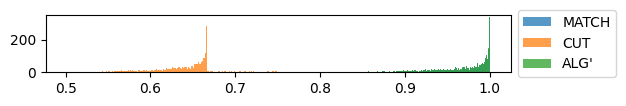

n=5: MATCH worst apx: 0.76, CUT worst apx: 0.51, ALG' worst apx: 0.79


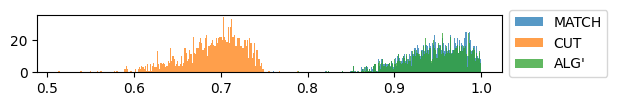

n=6: MATCH worst apx: 0.82, CUT worst apx: 0.54, ALG' worst apx: 0.82


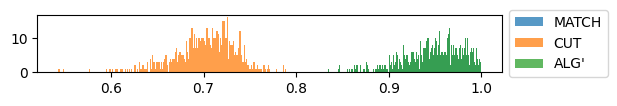

n=7: MATCH worst apx: 0.78, CUT worst apx: 0.61, ALG' worst apx: 0.79


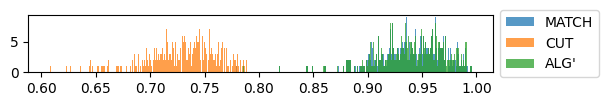

In [108]:
plot_hists_by_n(weighted_max_qmc_energies, ns=weighted_ns, unique_ns=weighted_unique_ns, match_energies=weighted_match_energies, prod_energies=weighted_cut_energies, alg_names=['MATCH', 'CUT', 'ALG\''])

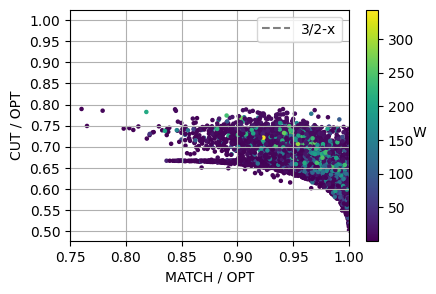

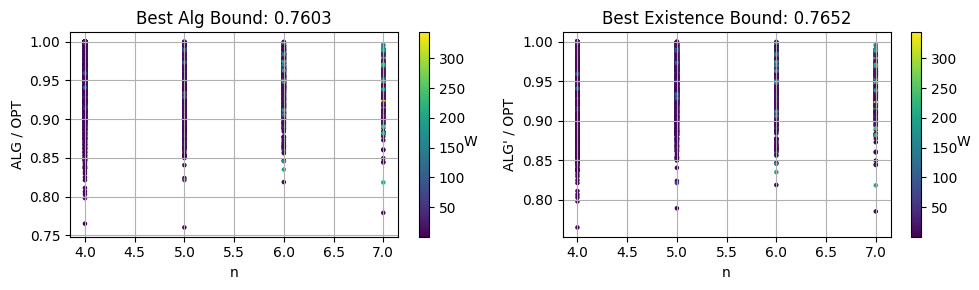

In [109]:
make_scatter_plots(weighted_max_qmc_energies, ns=weighted_ns, match_energies=weighted_match_energies, prod_energies=weighted_cut_energies, total_weights=weighted_total_weights, prod_alg_name='CUT', existence_bound=True, alg_prod_apx=PROD_APX, plot_bound=True)

EPR

n=4: MATCH worst apx: 0.76, ZERO worst apx: 0.50, ALG worst apx: 0.76


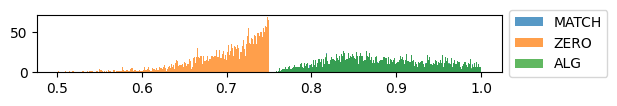

n=5: MATCH worst apx: 0.72, ZERO worst apx: 0.53, ALG worst apx: 0.78


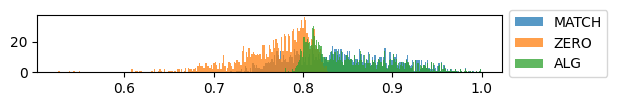

n=6: MATCH worst apx: 0.71, ZERO worst apx: 0.55, ALG worst apx: 0.78


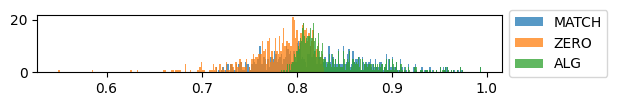

n=7: MATCH worst apx: 0.68, ZERO worst apx: 0.64, ALG worst apx: 0.79


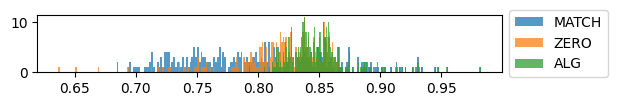

In [110]:
plot_hists_by_n(weighted_max_epr_energies, ns=weighted_ns, unique_ns=weighted_unique_ns, match_energies=weighted_match_energies, prod_energies=weighted_total_weights, alg_names=['MATCH', 'ZERO', 'ALG'])

XY

n=4: MATCH worst apx: 0.52, CUT worst apx: 0.50, ALG' worst apx: 0.71


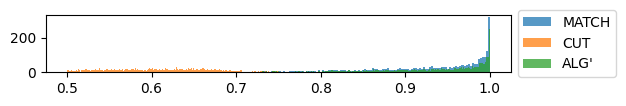

n=5: MATCH worst apx: 0.50, CUT worst apx: 0.51, ALG' worst apx: 0.72


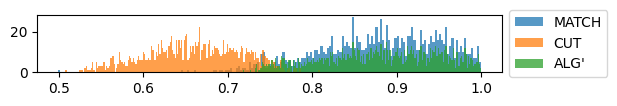

n=6: MATCH worst apx: 0.62, CUT worst apx: 0.52, ALG' worst apx: 0.71


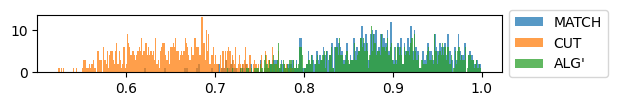

n=7: MATCH worst apx: 0.53, CUT worst apx: 0.55, ALG' worst apx: 0.73


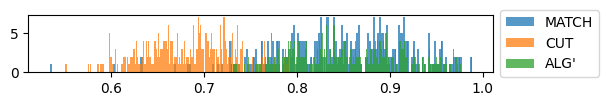

In [111]:
plot_hists_by_n(weighted_max_xy_energies, ns=weighted_ns, unique_ns=weighted_unique_ns, match_energies=weighted_match_energies_xy, prod_energies=weighted_cut_energies_xy, alg_names=['MATCH', 'CUT', 'ALG\''])

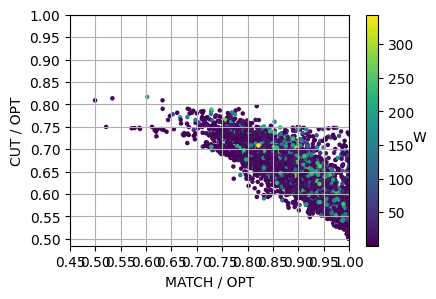

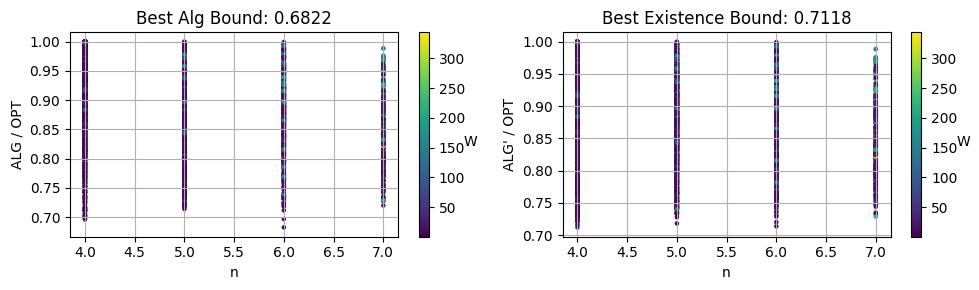

In [112]:
make_scatter_plots(weighted_max_xy_energies, ns=weighted_ns, match_energies=weighted_match_energies_xy, prod_energies=weighted_cut_energies_xy, total_weights=weighted_total_weights, prod_alg_name='CUT', existence_bound=True, alg_prod_apx=PROD_APX,plot_bound=False)

$XY^-$

n=4: MATCH worst apx: 0.51, ZERO worst apx: 0.50, ALG worst apx: 0.71


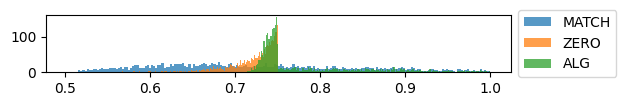

n=5: MATCH worst apx: 0.41, ZERO worst apx: 0.53, ALG worst apx: 0.73


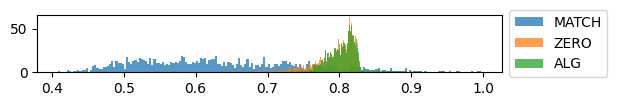

n=6: MATCH worst apx: 0.40, ZERO worst apx: 0.56, ALG worst apx: 0.72


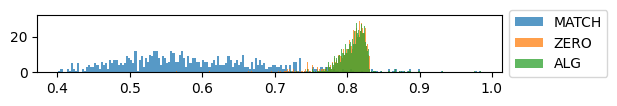

n=7: MATCH worst apx: 0.34, ZERO worst apx: 0.68, ALG worst apx: 0.78


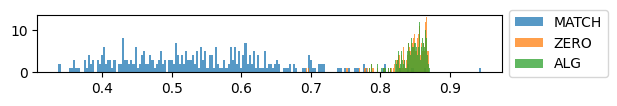

In [113]:
plot_hists_by_n(weighted_max_nxy_energies, ns=weighted_ns, unique_ns=weighted_unique_ns, match_energies=weighted_match_energies_xy, prod_energies=weighted_total_weights/2, alg_names=['MATCH', 'ZERO', 'ALG'])

##### Testing OPT always in k//2

In [114]:
for data in [weighted_max_Lk_energies, weighted_max_Qk_energies, weighted_max_Ak_energies, weighted_max_nAk_energies]:
    print(np.allclose(get_largest_spin_energies(data), get_max_spin_energies(data)))

True
True
True
False


In [117]:
fail_idxs = np.where(get_largest_spin_energies(weighted_max_nAk_energies) < get_max_spin_energies(weighted_max_nAk_energies)-TOL)[0]

In [118]:
len(fail_idxs)

18